# **DNN shrinking & quantization**

**Credits**: *Francesco Conti, Davide Nadalini, Lorenzo Lamberti, Luca Bompani, Alberto Dequino*.
*(University of Bologna)*

**Contacts**: f.conti@unibo.it

## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to quantize a CNN and how to visualize its graph

### Tasks:

---

1. Load a model’s pretrained weights;
2. Reduce network’s size under 5MMAC;
3. Re-train the reduced network and verify network’s accuracy;
4. Fake-quantize with Brevitas;
5. True-quantize with DeepQuant, export ONNX and analyze the float32 and true-quantized models with Netron.

---





## **Let's start !**

## Imports:
Now we import some packages  we will need:

In [1]:
#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import time

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#torchvision
import torchvision
from torchvision import transforms, datasets

# others
from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
from collections import defaultdict

# Brevitas
from typing import Union, Tuple, List, Dict
import brevitas.nn as qnn
from brevitas.graph.equalize import activation_equalization_mode



PyTorch version in use: 2.4.0 
cuda avail:  False


/tmp/ipykernel_15894/1887837515.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/brevitas/graph/equalize.py:61: UserWarning: fast_hadamard_transform package not found, using standard pytorch kernels
  warnings.warn("fast_hadamard_transform package not found, using standard pytorch kernels")


## Set device
Between "cuda" and "cpu"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cpu


# **Recap: how to train a toy network**
This section recaps how to define and train a simple toy network in PyTorch.

## Creating a Model
---



Let's define a simple NN topology:

In [3]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        # self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, 32,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(32, 64,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(64, 128, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*128
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        # self.softmax = nn.LogSoftmax(dim=1) # we remove it because the quantization tool (Quantlab) does not handle it

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        output = self.fc(x)
        # output = self.softmax(x)
        return output

net = CNN().to(device)


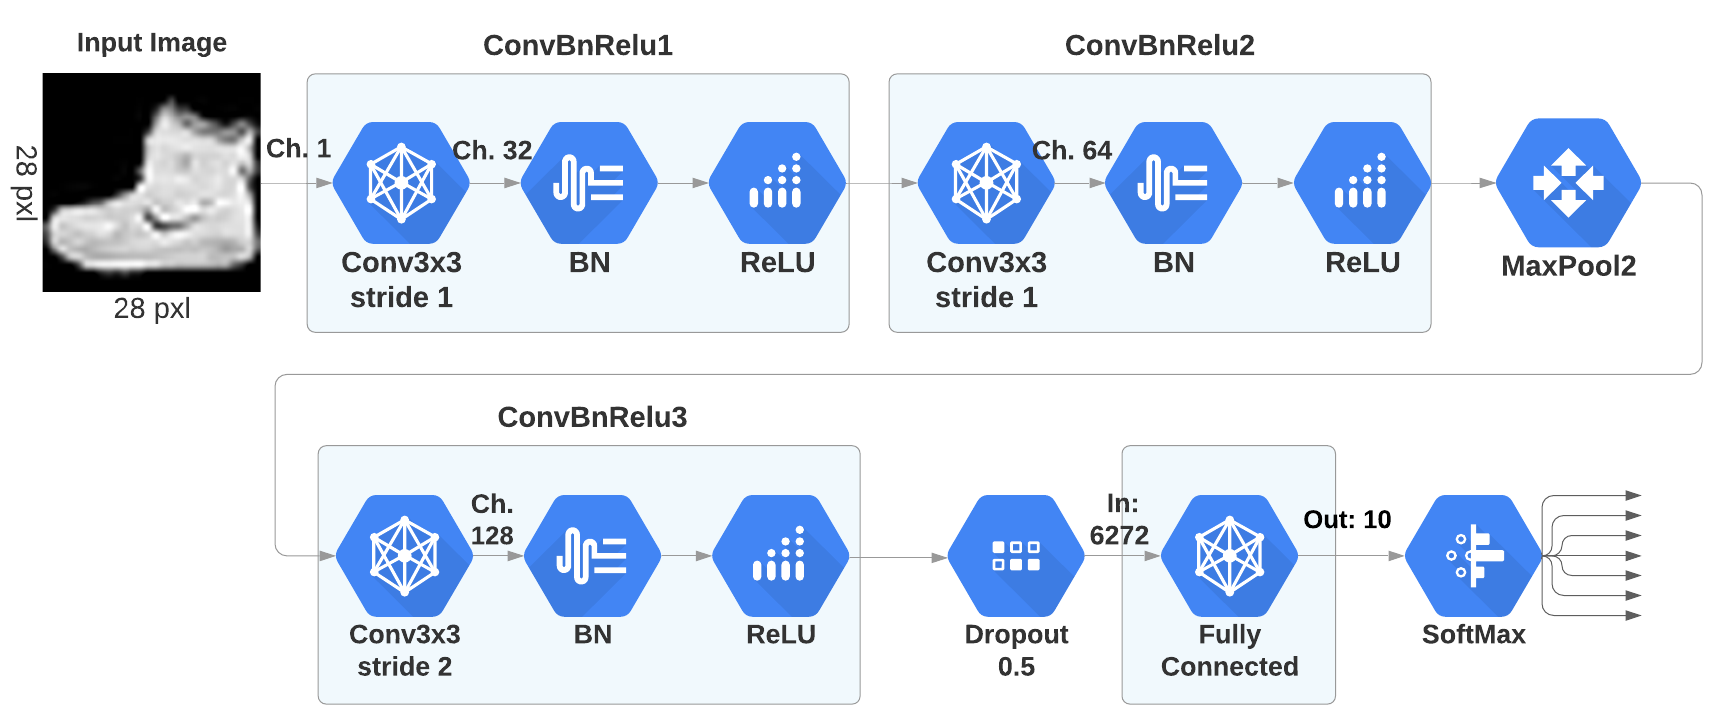

In [4]:
#@title Dummy input  { form-width: "70%" }
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (1, 1, 28, 28)  #@param
input = torch.randn(input_size).to(device)


## Count network's parameters and MAC operations

---

A useful function to measure the model's MAC operations and number of parameters.

**TorchInfo insights:**
This tool calculates the Parameters Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

In [5]:
def print_summary(net, input_size, verbose=True):
    from torchinfo import summary
    net_info = summary(net, input_size=input_size)
    params = net_info.total_params
    macs = net_info.total_mult_adds
    if verbose: print(net_info)
    return params, macs

# calculate n° parameters and mac operations
params, macs = print_summary(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls
# print them
print("\nNetwork's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─ConvBnRelu: 1-1                        [1, 32, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           288
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
├─ConvBnRelu: 1-2                        [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           18,432
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 64, 14, 14]           --
├─ConvBnRelu: 1-4                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-5                       [1, 128, 7, 7]            73,728
│    └─ReLU: 2-6                         [1, 128, 7, 7]            --
├─Dropout: 1-5                           [1, 128, 7, 7]            --
├─Linear: 1-6                            [1, 10]                   62,720
To

## Dataset & DataLoaders

---

We use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.

In [6]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, path='./data/fashionmnist',verbose=False):
    # 1. define data transformations
    fashion_mnist = datasets.FashionMNIST(download=True, train=True, root=path).train_data.float()
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    # 2. Load train/valid datasets
    train_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=True)
    valid_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=False)

    # 3. define dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=val_batch_size,
        shuffle=False)

    # Optional: count how many images we have in each set
    train_dataset_size = len(train_dataset)
    valid_dataset_size = len(valid_dataset)
    if verbose: print('Dataset size:\nTraining images %d,\nValidation images %d' % (train_dataset_size, valid_dataset_size))

    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders(verbose=True)


Dataset size:
Training images 60000,
Validation images 10000


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Testing the CNN over the dataset

---



### Accuracy Metric calculation

First we define a function to calculate the accuracy, defined as: `accuracy = num_correct_predictions/total_n_predictions`



In [7]:
def calculate_accuracy(best_guesses, targets):
    num_correct = torch.eq(targets, best_guesses).sum().item()
    total_guesses = len(targets)
    correct_percentage = num_correct/total_guesses
    return correct_percentage

### Testing Function
The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [8]:
from brevitas.export.inference import quant_inference_mode

def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []

    # set net to evaluating (testing)
    net.eval()
    with torch.no_grad(), quant_inference_mode(net):
        for batch_idx, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            outputs = net(inputs) # this gets the prediction from the network

            # calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))

    average_val_loss = sum(val_losses)/(batch_idx+1)
    average_val_accuracy = sum(val_accuracy)/len(val_loader)
    return average_val_accuracy, average_val_loss


## Training Loop

In [9]:
# Move net to gpu:
net.to(device)

# Define loss function
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems


def training(net, train_loader, val_loader, loss_function, epochs, lr=3e-4):
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # count tot batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=tot_train_batches)

        # ----------------- TRAINING  -------------------- #
        # set model to training
        net.train()

        for batch_idx, data in progress:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Compute prediction (forward input in the model)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Backpropagation
            net.zero_grad()
            loss.backward()
            # Optimizer step
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()

            #compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss/(batch_idx+1)

            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))
            average_train_accuracy = sum(train_accuracy)/(batch_idx+1)

            # updating progress bar
            progress.set_description("Training Loss: {:.4f}, Accuracy: {:.4f}".format(average_train_loss, average_train_accuracy))

            ## DEBUG: stop after one single batch
            # break

        # ----------------- VALIDATION  ----------------- #
        average_val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)

        # compute mean accuracy
        average_train_accuracy = sum(train_accuracy)/tot_train_batches

        # print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch+1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(average_train_loss)
        val_loss_history.append(average_val_loss)
        train_accuracy_history.append(average_train_accuracy)
        val_accuracy_history.append(average_val_accuracy)

    print('Training time: %.1f seconds' % (time.time()-start_ts))


    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

# retrain the network
epochs = 1
_, _, _, _= training(net, train_loader, val_loader, loss_function, epochs)

100%|██████████| 79/79 [00:03<00:00, 21.48it/s]

Epoch 1/1 Training loss:  0.5591 Accuracy: 0.8034
Validation Loss: 0.3866 Accuracy: 0.8628
Training time: 149.5 seconds


## Save/Load the CNN weights


In [9]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


In [10]:
def save_net(net,model_path, model_name):
    #Save Pytorch model
    torch.save(net.state_dict(), join(model_path,model_name))

save_net(net,model_export_path, model_name)

In [11]:
def load_net(net, model_path, model_name, device):
    ''' Load a PyTorch Model '''
    checkpoint_file= join(model_path,model_name)
    # load weights file
    state_dict = torch.load(checkpoint_file, map_location=device)
    # Load weights into the network
    net.load_state_dict(state_dict)
    # to device (cpu or gpu)
    net = CNN().to(device)
    return net

# **TASK1:** Load Pre-Trained Model

---



Let's download pre-trained weights for the network.
I already prepared them for you in our [GitHub repo](https://github.com/EEESlab/APAI24-LAB03-DNN-Shrinking-and-Quantization/blob/master/ExampleNet.pth) 🙂
(search for `ExampleNet.pth` file)

In [12]:
!rm -r APAI24-LAB03-DNN-Shrinking-and-Quantization

!git clone https://github.com/EEESlab/APAI24-LAB03-DNN-Shrinking-and-Quantization

Cloning into 'APAI24-LAB03-DNN-Shrinking-and-Quantization'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 27 (delta 11), reused 21 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 2.18 MiB | 4.83 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [15]:
#FIXME

#@title define path for cnn's pre-trained weights { form-width: "70%" }
# pre_trained_path = "./APAI24-LAB03-DNN-Shrinking-and-Quantization/" #@param {type:"string"}
pre_trained_path = "./model"
model_name = 'ExampleNet.pth' #@param {type:"string"}


### Load pre-trained weights

In [16]:
load_net(net, pre_trained_path, model_name, 'cpu')

/tmp/ipykernel_15894/2733931076.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_file, map_location=device)


CNN(
  (ConvBnRelu1): ConvBnRelu(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu1): ReLU()
  )
  (ConvBnRelu2): ConvBnRelu(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvBnRelu3): ConvBnRelu(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (relu1): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=6272, out_features=10, bias=False)
)

Test again the network accuracy, to be sure that you saved/loaded weights correctly.



In [17]:
# Test over validation dataset
loss_function=nn.CrossEntropyLoss()
average_val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:04<00:00, 18.81it/s]

Validation Loss: 2.3008 Accuracy: 0.1210


**if accuracy ~ 90% : you were successful !!**

# **TASK2:** Reduce Network's MAC operations

---
**ASSIGNMENT TASK:**

Current network has:
*   n°params: 155.616k
*   MAC: 18.515M

**Task:** Reduce it below 5 MMAC, but keeping accuracy similar to the starting one. You have several techniques available:
1. change the depth multiplier (number of intermediate channels = 32*depth mult)
2. add or remove layers
3. play with the stride of convolutional layers

---

## New network with reduced size

In [17]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN_reduced(nn.Module):
    
    def __init__(self, n_classes=10):
        super(CNN_reduced, self).__init__()
        # first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, 16,  stride=1) # conv3x3: ch_in=1, ch_out=16, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(16, 32,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(32, 64, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*64
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        output = self.fc(x)
        return output

net_reduced = CNN_reduced().to(device)


Let's see how many MAC operations the new network has...

In [18]:
params, macs = print_summary(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls
print("\nNetwork's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_reduced                              [1, 10]                   --
├─ConvBnRelu: 1-1                        [1, 16, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           144
│    └─BatchNorm2d: 2-2                  [1, 16, 28, 28]           32
│    └─ReLU: 2-3                         [1, 16, 28, 28]           --
├─ConvBnRelu: 1-2                        [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           4,608
│    └─BatchNorm2d: 2-5                  [1, 32, 28, 28]           64
│    └─ReLU: 2-6                         [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─ConvBnRelu: 1-4                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 64, 7, 7]             18,432
│    └─BatchNorm2d: 2-8                  [1, 64, 7, 7]             128
│    └

**The New network has 4.66M MAC, which is less than our constrain of 5M !!**

# **TASK3:** Retrain the network and verify validation accuracy

You can use the same training loop as in the previous task:



In [18]:
#@title Training parameters { form-width: "70%" }
epochs = 1 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [19]:
# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

In [20]:
# Train the network!
(train_loss_history,
train_accuracy_history,
val_loss_history,
val_accuracy_history) = training(net_reduced, train_loader, val_loader, loss_function, epochs)

NameError: name 'training' is not defined

# **TASK4**: Quantization

We want to quantize the network from a float32 representation to an _integer_ representation. As we studied in class, quantization is a technique that allow us to compress the neural network (i.e., reduce its size) and potentially to accelerate the inference time (float operations vs int operations). First, we'll use a "soft" technique called Post-Training Quantization to quantize our network _without_ retraining it.

We will use the open-source [**Brevitas**](https://github.com/Xilinx/brevitas) tool, developed by AMD Xilinx, as our main quantization framework. Resources:
 * https://xilinx.github.io/brevitas/

The computational graph of our network uses floating-point operands, i.e., it is a floating-point computational graph.

Similarly to other quantization tools, the first step of Brevitas' operation is to replace the nodes in the graph with ones that support quantization, i.e., explicitly include weight and (potentially) activation quantization in their `forward` methods.
Quantization-aware nodes also make it possible to collect statistics on the weight and activation distribution, which on turn are usede to improve the quantization itself by selecting the correct quantization range.
This information will be transformed into a set of floating-point zero-offsets and scaling factors applied to integer weights and activations.

The conversion from a "pure" model to one that is quantization-aware is called the fake quantization, and it produces a **Fake-Quantized (FQ)** model: specifically the FQ step introduces linear quantizers into the computational graph, but at the same time continues to operate with floating-point operands.
In Brevitas, fake quantization can be performed *layer-wise*, i.e., looking at one `torch.nn.Module` at a time, or referring to a `torch.fx` trace.
The latter strategy is potentially more powerful for complex models, but also less simple to use: in this tutorial, we'll rely on the former one.

The FQ graph is where we apply all transformation that still require complete trainability and, as a consequence, rely on float representation.
However, the FQ graph cannot be directly deployed as it typically ignores some of the nodes (such as activations); scaling factors are applied in floating-point, which we generally want to avoid; and in general it is not a bit-true representation of any full-integer operation that will happen in deployment.
We'll need a separate tool to perform a second-stage transformation to get to a fully integer graph.

## **1st quantization step: Float-to-fake**

This is the first step for preparing & converting a conventional neural network to the quantized form, which is where “fake quantization” nodes come in (image below: red nodes):

* The role that fake quantization nodes fulfil is to simulate the rounding effect of quantization in the forward pass, as it would occur in actual inference of a quantized network. So we are not converting activation's output
and the convolutional weights to fixed-point representation (`integer`), we are just adding a "fake quantization" node that simulates the effect of quantization. This allows to keep all parameters stored as float with the real full-precision.

***Why do we want to keep the original `float32` values?***

* It is mandatory at training time, so that backpropagation still works as usual. A quantized network would have no way to be trained and updated with infinitesimal gradients.

***Why do we want to train a quantized network then ?***

* Frequently, after applying quantization, we must run a few epochs of fine-tuning (called **quantization-aware training**) to adjust for the precision loss introduced by a lower bitwidth.
* The alternative, which we'll follow in the first part of this tutorial, is to apply **post-training quantization**, which relies on statistics collection and calibration to adapt the ranges and scaling factors of quantizers.

**Summary:** Fake quantization nodes simulates the quantization effects on weights and output activations just during the forward pass (`input->output`). While during backpropagation (`input<-output`) the fake quantization nodes are not active and the weights and activations retain their original `float32` values.


Figure2.png

To perform F2F conversion, we must replace standard PyTorch Modules with corresponding FakeQuantized counterparts.
With Brevitas, we start by taking a "deep copy" of our initial floating-point net (to keep it untouched), then we operate on the copy.

Our first step is to perform *activation equalization*, a technique based on [**SmoothQuant**](https://arxiv.org/abs/2211.10438) used to smooth out any outliers in the activation distribution by migrating their "quantization difficulty" towards weights.
This is directly supported in Brevitas and can be run to our copied network as a preliminary step.
Afterwards, we run one validation round to double-check functionality.

In [21]:
from copy import deepcopy

# DeepCopy of net + ugly bias workaround
net_copy = deepcopy(net)

for layer in [net_copy.ConvBnRelu1.conv1, net_copy.ConvBnRelu2.conv1, net_copy.ConvBnRelu3.conv1, net_copy.fc]:
    layer.bias = torch.nn.Parameter(torch.zeros(layer.weight.size()[0]))

In [22]:
from brevitas.graph.calibrate import bias_correction_mode, calibration_mode
from brevitas.graph.equalize import activation_equalization_mode

def equalize_activations(net, cal_loader, alpha=0.5):

    # set net to evaluating (testing)
    net.eval()
    with activation_equalization_mode(net, alpha):
      with torch.no_grad():
          for batch_idx, data in enumerate(cal_loader):
              inputs, _ = data[0].to(device), data[1].to(device)

              # net forward
              _ = net(inputs) # this gets the prediction from the network

# use validation set for activation equalization
calib_loader = val_loader
equalize_activations(net_copy, calib_loader)

average_val_accuracy, average_val_loss = validate(net_copy, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

100%|██████████| 79/79 [00:04<00:00, 18.25it/s]

Validation Loss: 2.3008 Accuracy: 0.1210


We expect the accuracy to be virtually unchanged compared to before equalization.

After equalization, we can perform the actual network fake-quantization, which in Brevitas is done through the `quantize_model` API. Here we make several choices:
 * the backend selected is `layerwise`. This is used to select whether `torch.nn.Module`s are being transformed one by one, or if the full graph produced by `torch.fx` is managed.
 * we select the bit width for weights (8b), activation (8b), bias (32b).
 * we select the granularity of weight quantization: `per_tensor` means that one single scaling factor (and a related range from `wmin` to `wmax`) is used for all the weights.
 * `act_quant_percentile` is used in calibration: in this case, we select to keep activation up to the 99.999% percentile within the representable range. Reducing the range might make it easier to quantize, but will result in gross precision loss on activation outliers. We also select the `act_quant_type` as `sym`metric (i.e., representable data goes from -N to +N).
 * as `scale_factor_type` we select `float_scale`, which means that quantization will be free to use any scaling factor. Conversely, we could also set up quantization to use only power-of-two scaling factors: this makes it possible to reduce all normalization to simple shifts (practically a regular fixed-point representation), at the price of losing flexibility, and thus accuracy.

After this step, we perform another accuracy evaluation to check for functionality.

In [23]:
from brevitas.graph.quantize import preprocess_for_quantize
gnet = preprocess_for_quantize(net_copy)

average_val_accuracy, average_val_loss = validate(gnet, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

100%|██████████| 79/79 [00:04<00:00, 19.55it/s]

Validation Loss: 2.3008 Accuracy: 0.1210


In [24]:
# from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model
from brevitas.export.inference import quant_inference_mode
from brevitas.graph.quantize import quantize
from brevitas.quant import (
  Int8ActPerTensorFloat,
  Int8WeightPerTensorFloat,
  Int32Bias,
  Uint8ActPerTensorFloat,
)

computeLayerMap = {
  nn.Conv2d: (
    qnn.QuantConv2d,
    {
      "input_quant": Int8ActPerTensorFloat,
      "weight_quant": Int8WeightPerTensorFloat,
      "output_quant": Int8ActPerTensorFloat,
      "bias_quant": Int32Bias,
      "bias": True,
      "return_quant_tensor": True,
      "output_bit_width": 8,
      "weight_bit_width": 8,
    },
  ),
  nn.Linear: (
    qnn.QuantLinear,
    {
      "input_quant": Int8ActPerTensorFloat,
      "weight_quant": Int8WeightPerTensorFloat,
      "output_quant": Int8ActPerTensorFloat,
      "bias_quant": Int32Bias,
      "bias": True,
      "return_quant_tensor": True,
      "output_bit_width": 8,
      "weight_bit_width": 8,
    },
  ),
  nn.BatchNorm2d: (
    qnn.BatchNorm2dToQuantScaleBias,
    {
      'weight_quant': Int8WeightPerTensorFloat,
      'bias_quant': Int32Bias,
      'return_quant_tensor': True
    }
  ),
}

quantActMap = {
  nn.ReLU: (
    qnn.QuantReLU,
    {
      "act_quant": Uint8ActPerTensorFloat,
      "return_quant_tensor": True,
      "bit_width": 8,
    },
  ),
}

quantIdentityMap = {
  "signed": (
    qnn.QuantIdentity,
    {
      "act_quant": Int8ActPerTensorFloat,
      "return_quant_tensor": True,
      "bit_width": 8,
    },
  ),
  "unsigned": (
    qnn.QuantIdentity,
    {
      "act_quant": Uint8ActPerTensorFloat,
      "return_quant_tensor": True,
      "bit_width": 8,
    },
  ),
}

qnet = quantize(
  graph_model=gnet,
  compute_layer_map=computeLayerMap,
  quant_act_map=quantActMap,
  quant_identity_map=quantIdentityMap,
)


# Test over validation dataset
loss_function=nn.CrossEntropyLoss()

average_val_accuracy, average_val_loss = validate(qnet, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1925.)
  return super().rename(names)
100%|██████████| 79/79 [00:10<00:00,  7.42it/s]

Validation Loss: 2.3024 Accuracy: 0.1276


---
**ASSIGNMENT TASK:**

Try to change the quantization options and explore the effects on accuracy. What happens if you reduce activation and/or weight bitwidth? And signedness?

---

Did you notice the accuracy drop? It should be around 7%. We should do something about it!
But before that, let us check the topology of the network. Spoiler: it is very different!

In [25]:
qnet.print_readable()

class CNN(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        x_quant = self.x_quant(x);  x = None
        conv_bn_relu1_conv1_scale_weight = self.ConvBnRelu1.conv1.scale.weight
        view = conv_bn_relu1_conv1_scale_weight.view([1, 1, 1, 1]);  conv_bn_relu1_conv1_scale_weight = None
        mul = x_quant * view;  x_quant = view = None
        conv_bn_relu1_conv1_layer = self.ConvBnRelu1.conv1.layer(mul);  mul = None
        conv_bn_relu1_relu1 = self.ConvBnRelu1.relu1(conv_bn_relu1_conv1_layer);  conv_bn_relu1_conv1_layer = None
        conv_bn_relu2_conv1_scale_weight = self.ConvBnRelu2.conv1.scale.weight
        view_1 = conv_bn_relu2_conv1_scale_weight.view([1, 32, 1, 1]);  conv_bn_relu2_conv1_scale_weight = None
        mul_1 = conv_bn_relu1_relu1 * view_1;  conv_bn_relu1_relu1 = view_1 = None
        conv_bn_relu2_conv1_layer = self.ConvBnRelu2.conv1.layer(mul_1);  mul_1 = None
        conv_bn_relu2_relu1 = self.ConvBnRelu2.relu

/usr/local/lib/python3.10/dist-packages/brevitas/backport/fx/experimental/proxy_tensor.py:97: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  pytree._register_pytree_node(torch.Size, lambda x: (list(x), None), lambda xs, _: tuple(xs))
/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:332: UserWarning: <class 'torch.Size'> is already registered as pytree node. Overwriting the previous registration.
  warnings.warn(


'class CNN(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        x_quant = self.x_quant(x);  x = None\n        conv_bn_relu1_conv1_scale_weight = self.ConvBnRelu1.conv1.scale.weight\n        view = conv_bn_relu1_conv1_scale_weight.view([1, 1, 1, 1]);  conv_bn_relu1_conv1_scale_weight = None\n        mul = x_quant * view;  x_quant = view = None\n        conv_bn_relu1_conv1_layer = self.ConvBnRelu1.conv1.layer(mul);  mul = None\n        conv_bn_relu1_relu1 = self.ConvBnRelu1.relu1(conv_bn_relu1_conv1_layer);  conv_bn_relu1_conv1_layer = None\n        conv_bn_relu2_conv1_scale_weight = self.ConvBnRelu2.conv1.scale.weight\n        view_1 = conv_bn_relu2_conv1_scale_weight.view([1, 32, 1, 1]);  conv_bn_relu2_conv1_scale_weight = None\n        mul_1 = conv_bn_relu1_relu1 * view_1;  conv_bn_relu1_relu1 = view_1 = None\n        conv_bn_relu2_conv1_layer = self.ConvBnRelu2.conv1.layer(mul_1);  mul_1 = None\n        conv_bn_relu2_relu1 = self.Co

To fix network accuracy, we need to initialize correctly the minima and maxima of activations, which is used to correctly represent them in the latter operations. This step is typically called calibration and, in PTQ, it is the only typically necessary step to achieve good performance. We expect virtually no accuracy loss compared to the floating-point network after calibration.

In [26]:
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate

#FIXME move to with "explicit" form
calib_loader = val_loader
# initializes wmax,wmin, amax, amin
calibrate(calib_loader, qnet)

# Test over validation dataset
loss_function=nn.CrossEntropyLoss()
with torch.no_grad(), quant_inference_mode(qnet):
  average_val_accuracy, average_val_loss = validate(qnet, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

100%|██████████| 79/79 [00:06<00:00, 11.74it/s]

Validation Loss: 2.3008 Accuracy: 0.1226


At this stage, the FQ of the network is complete. Try to progressively reduce the target bitwidth to less than 8b for weights and activations: what happens? Also check what happens, particularly with low bitwidth, if you remove equalization or calibration. Finally, explore what happens if you replace the "original" model with the one you shrinked.
Each time, start back from the equalization phase, where you copied `net` in `net_copy`.

## **2nd quantization step: Quantization-aware training (QAT)**

After applying quantization, we can run a few epochs  (just 1 enough in this case)  of fine-tuning, called *Quantization-Aware Training (QAT)*, to adjust for the precision loss introduced by a lower bitwidth.
This is particularly useful if we target very low bitwidth networks.

Let's define the Quantization-Aware Training function:

In [28]:
#@title Number of quatization-aware training (QAT) epochs { form-width: "70%" }
n_QAT_epochs = 1 #@param {type:"integer"}

Start Quantization-aware fine-tuning !


In [29]:
# Train the network!
(train_loss_history,
train_accuracy_history,
val_loss_history,
val_accuracy_history) = training(qnet, train_loader, val_loader, loss_function, n_QAT_epochs, lr=1e-5)

Training Loss: 0.3885, Accuracy: 0.8613:  17%|█▋        | 80/469 [00:38<03:05,  2.10it/s]


KeyboardInterrupt: 

In [ ]:
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate

#FIXME move to with "explicit" forma
calib_loader = val_loader
# initializes wmax,wmin, amax, amin
calibrate(calib_loader, qnet)

# Test over validation dataset
loss_function=nn.CrossEntropyLoss()
with torch.no_grad(), quant_inference_mode(qnet):
  average_val_accuracy, average_val_loss = validate(qnet, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

100%|██████████| 79/79 [00:05<00:00, 13.58it/s]

Validation Loss: 0.3675 Accuracy: 0.8708


---
**ASSIGNMENT TASK:**

What is the difference between PTQ and QAT? Explore what happens when you change the target precision in terms of weight and activation bits.

---

## **3rd quantization step: Fake-to-true**

At this stage, we drop the "fake-quantization nodes" (the red nodes in the figure) and we transform all parameters to a fully integer representation, dropping the original `float32` values.
For doing so, we must freeze the `min` and `max` range and the scaling factor for the input, also called *quantum*. This process is called **True Quantization (TQ)**.

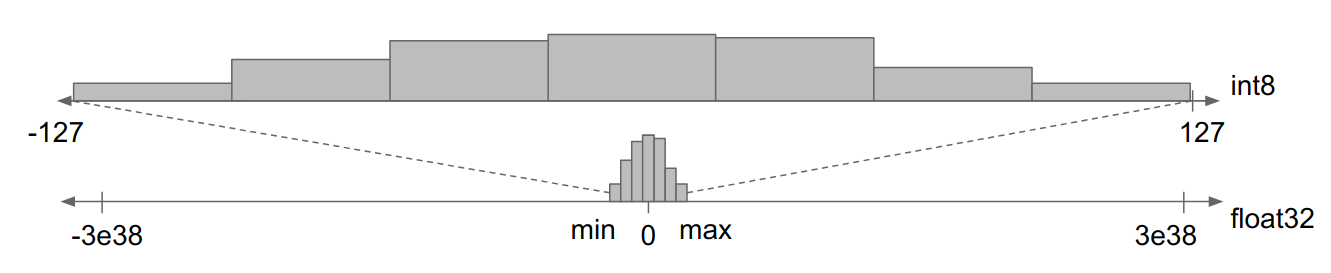

We perform this transformation using **DeepQuant**, a PULP platform tool that is specialized in transforming the FQ output of Brevitas and bringing it to TQ.
DeepQuant operates in a nearly automatic way.
DeepQuant is in *alpha* stage: do not expect everything to work smoothly!

In [ ]:
# roll back to PTQ?

In [27]:
#@title fake-to-true (F2T) function {form-width: "30%"}

from DeepQuant.DeepQuant import brevitasToTrueQuant
sampleInput = torch.randn(1, 1, 28, 28)
tqnet = brevitasToTrueQuant(qnet, sampleInput, exportPath="./DeepQuantTest", debug=True)


1. Original Network
┍━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ opcode        │ class         │ name                             │ target                         │
┝━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ placeholder   │               │ x                                │ x                              │
├───────────────┼───────────────┼──────────────────────────────────┼────────────────────────────────┤
│ call_module   │ QuantIdentity │ x_quant                          │ x_quant                        │
├───────────────┼───────────────┼──────────────────────────────────┼────────────────────────────────┤
│ get_attr      │               │ conv_bn_relu1_conv1_scale_weight │ ConvBnRelu1.conv1.scale.weight │
├───────────────┼───────────────┼──────────────────────────────────┼────────────────────────────────┤
│ call_method   │               │ view                       

A sanity check: we compare the predictions of the fully-integerised program with the ground truth to verify that they are coherent.


In [ ]:
#@title Sanity check {form-width: "30%"}
import random
random_idx = random.randrange(0, len(val_loader.dataset))
# pick random image from dataset
x, y_gt_int = val_loader.dataset.__getitem__(random_idx)
x = x.unsqueeze(0)
net.to('cpu')
# prediction original float32 network
y_pr_float = net(x)
y_pr_float_max = y_pr_float.argmax(axis=1)

x, y_gt_int = val_loader.dataset.__getitem__(random_idx)
x = x.unsqueeze(0)
# prediction quantized network
y_pr = tqnet(x)
y_pr_int = y_pr.argmax(axis=1)

print("True Quantized: \t\tTrue: {} - Predicted: {}".format(int(y_gt_int), y_pr_int.item()))
print("FLOAT32:\tTrue: {} - Predicted: {}\n".format(int(y_gt_int), y_pr_float_max.item()))

True Quantized: 		True: 0 - Predicted: 0
FLOAT32:	True: 0 - Predicted: 0



let's verify that the accuracy didn't drop between FLOAT32 and TrueQuantized stages.

In [ ]:
# Test the NON QUANTIZED network over validation dataset
average_val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('FLOAT32 Validation Accuracy: %.4f' % (average_val_accuracy))

FLOAT32 Validation Accuracy: 0.9008


In [ ]:
# Test the QUANTIZED network over validation dataset
average_val_accuracy, average_val_loss = validate(tqnet, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('INT Validation Accuracy: %.4f' % (average_val_accuracy))

100%|██████████| 79/79 [00:07<00:00, 10.64it/s]

INT Validation Accuracy: 0.9011


# **Task5:** Export to ONNX format


The trained networks can be exported in [**ONNX (*Open Neural Network eXchange*)**)](https://github.com/onnx/onnx) format for  deployment tools. This format is recognized as the official format to export a deep neural network. This format stores all the necessary elements to reload a network:
* topology: number of layers, how they are linked and their type;
* layer structure: stride, filter dimension, channels, etc..
* parameters: for each layer, all the weights and numeric parameters are stored.

**How to use:** To see how the model looks like, the following cells will
1) trigger a download to your local machine, and 2)  open a frame into Colab to a tool called [Netron](https://netron.app). This tool that can be used to visualize it: just drag the ONNX file and drop it on top of the Netron frame!


**IMPORTANT:** now we are going to visualize two networks: 1. the original float32 network (so, the non-quantized one), and 2) the quantized one.


### **1. Export the original Float32 model (non-quantized!)**

Export the ONNX file of the NON-quantized network.


In [ ]:
net.eval()
torch.onnx.export(net, input, 'ExampleNet_Float32.onnx')

Open Netron and visualize the non-quantized network, named: `ExampleNet_Float32`, by loading it to Netron.
That is, accept cookies, and "open model" by dragging and dropping the file you downloaded.

In [ ]:
#@title Open Netron {form-width: "30%"}
import urllib
from IPython.display import IFrame
url = urllib.parse.quote("https://netron.app/", safe=':/?=&')
IFrame(url, width=800, height=600)

---
**ASSIGNMENT TASK:**

Use Netron to analyze the ONNX file of the original NON QUANTIZED network and answer the following question:

* What's the data format of the convolutional layers' weights?
* Is the decial part of the convolutional weights !=0 ?  Paste here the value of a single weight as an example.
* What's the kernel size of all the convolutions?

---

### **2. Study the Quantized model**

Open Netron and visualize the quantized network, named: `DeepQuantTest/network.onnx`


In [ ]:
#@title Open Netron {form-width: "30%"}

import urllib
from IPython.display import IFrame
url = urllib.parse.quote("https://netron.app/", safe=':/?=&')
IFrame(url, width=800, height=600) # you can resize the Netron frame size here!

---
**ASSIGNMENT TASK:**

Use Netron to analyze the ONNX file of the QUANTIZED network and answer the following question:

* What's the size of the input image?
* What's the data format of all the convolutional weights?
* Is the decimal part of the convolutional weights !=0 ? . Paste here the value of a single weight as an example.
* What's the quantization bitwidth of the `ConvBnRelu1` convolutional weights? (hint: look at their min/max!)
* What's the quantization bitwidth of the `ConvBnRelu2` convolutional weights?
* What's the kernel size of all the convolutions?

---